In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from scipy.stats import boxcox
import sklearn.preprocessing as sklearn
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import iqr
from scipy.stats import scoreatpercentile as pct
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
import statsmodels.api as sm

In [2]:
df = pd.read_excel("Data/midterm_project_cleaned.xlsx")

In [3]:
df.shape

(21596, 25)

In [4]:
df.zipcode.value_counts()

98103    601
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [5]:
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [6]:
df['avg_price_per_zipcode'] = round(df.groupby(['zipcode'])['price'].transform('mean'),2)

In [9]:
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,long,sqft_living15,sqft_lot15,price,renovated,basement,decade,geo1,geo2,avg_price_per_zipcode
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,-122.257,1340,5650,221900,False,False,Category B,centre,west,310612.76
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,-122.319,1690,7639,538000,True,True,Category B,north,west,469928.77
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,-122.233,2720,8062,180000,False,False,Category B,north,west,462488.87
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,-122.393,1360,5000,604000,False,True,Category C,centre,west,551768.52
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,-122.045,1800,7503,510000,False,False,Category C,north,centre,685675.84


In [10]:
# Dropping highly correlated columns sqft_living and sqft_above
## sqft_living: living area of the home; area that can be heated or cooled 
## sqft_above: area above the basement; living area minus attic
df.drop(["sqft_above"], axis = 1, inplace = True)

In [11]:
decade_dict = {"Category A": 1, "Category B": 2, "Category C": 3, "Category D": 4}
df = df.replace({"decade": decade_dict})

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21596 entries, 0 to 21595
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bedrooms               21596 non-null  int64  
 1   bathrooms              21596 non-null  float64
 2   sqft_living            21596 non-null  int64  
 3   sqft_lot               21596 non-null  int64  
 4   floors                 21596 non-null  float64
 5   waterfront             21596 non-null  int64  
 6   view                   21596 non-null  int64  
 7   condition              21596 non-null  int64  
 8   grade                  21596 non-null  int64  
 9   sqft_basement          21596 non-null  int64  
 10  yr_built               21596 non-null  int64  
 11  yr_renovated           21596 non-null  int64  
 12  zipcode                21596 non-null  int64  
 13  lat                    21596 non-null  float64
 14  long                   21596 non-null  float64
 15  sq

In [13]:
# Looking for highly correlated columns

correlation_matrix = df.corr()
correlation_matrix

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,...,zipcode,lat,long,sqft_living15,sqft_lot15,price,renovated,basement,decade,avg_price_per_zipcode
bedrooms,1.000000,0.527870,0.593178,0.033602,0.183707,-0.006869,0.082437,0.023440,0.366174,0.309261,...,-0.158588,-0.011595,0.136561,0.404532,0.031892,0.315961,0.018864,0.164290,0.172309,0.127754
bathrooms,0.527870,1.000000,0.755755,0.088368,0.502574,0.063742,0.188381,-0.126443,0.665834,0.283459,...,-0.204778,0.024301,0.224889,0.569878,0.088297,0.525915,0.050060,0.162800,0.501921,0.226701
sqft_living,0.593178,0.755755,1.000000,0.173449,0.353941,0.103853,0.284704,-0.059397,0.762776,0.435152,...,-0.199793,0.052178,0.241200,0.756400,0.184337,0.701929,0.055034,0.204362,0.320454,0.298193
sqft_lot,0.033602,0.088368,0.173449,1.000000,-0.004824,0.021631,0.074897,-0.008806,0.114726,0.015424,...,-0.129582,-0.085507,0.230222,0.144756,0.718203,0.089879,0.007786,-0.035216,0.060792,-0.031810
floors,0.183707,0.502574,0.353941,-0.004824,1.000000,0.023752,0.028801,-0.264013,0.458783,-0.245694,...,-0.059522,0.049280,0.125912,0.280072,-0.010734,0.256820,0.006340,-0.256507,0.477603,0.128769
waterfront,-0.006869,0.063742,0.103853,0.021631,0.023752,1.000000,0.401970,0.016624,0.082886,0.080562,...,0.030274,-0.014302,-0.041908,0.086505,0.030780,0.266400,0.093281,0.037190,-0.023430,0.017363
view,0.082437,0.188381,0.284704,0.074897,0.028801,0.401970,1.000000,0.046041,0.251722,0.277090,...,0.084629,0.005884,-0.078120,0.280674,0.072900,0.397376,0.104093,0.181939,-0.052666,0.099872
condition,0.023440,-0.126443,-0.059397,-0.008806,-0.264013,0.016624,0.046041,1.000000,-0.146854,0.173801,...,0.002835,-0.015209,-0.105800,-0.092979,-0.003093,0.036031,-0.060294,0.135094,-0.348195,0.051390
grade,0.366174,0.665834,0.762776,0.114726,0.458783,0.082886,0.251722,-0.146854,1.000000,0.168240,...,-0.185761,0.113602,0.200324,0.713863,0.120974,0.667964,0.013848,0.051289,0.440088,0.372017
sqft_basement,0.309261,0.283459,0.435152,0.015424,-0.245694,0.080562,0.277090,0.173801,0.168240,1.000000,...,0.074712,0.110389,-0.144525,0.200478,0.017559,0.323794,0.070881,0.819087,-0.130853,0.170017


<AxesSubplot:title={'center':'Heatmap'}>

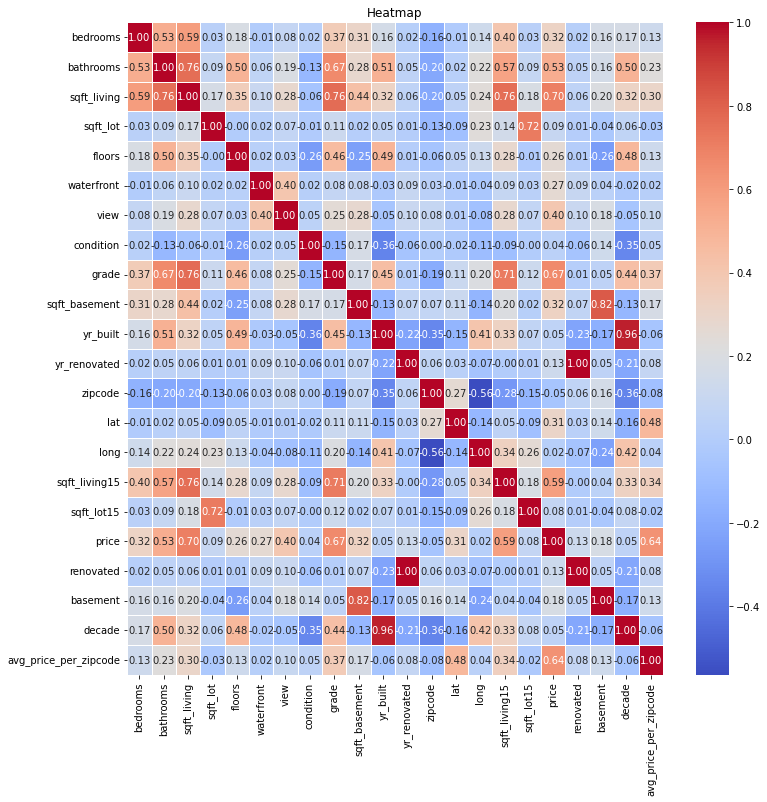

In [14]:
fig5, ax = plt.subplots(figsize = (12,12))

ax.set_title("Heatmap")

sns.heatmap(correlation_matrix,  
            cmap = "coolwarm", 
            linewidth = 1, 
            annot = True, 
            fmt = ".2f")

fig, axe = plt.subplots(2,3,figsize = (14,12))

sns.histplot(df, x=df.loc[:, "sqft_living"], ax = axe[0,0]) 
sns.histplot(df, x=df.loc[:, "sqft_lot"], ax = axe [0,1])
sns.histplot(df, x=df.loc[:, "sqft_basement"], ax = axe [0,2])
sns.histplot(df, x=df.loc[:, "sqft_living15"], ax = axe [1,0])
sns.histplot(df, x=df.loc[:, "sqft_lot15"], ax = axe [1,1])

In [15]:
# X/y split
X = df.drop("price", axis=1)
y = df["price"]

In [16]:
# Train/test split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

In [17]:
X_train.reset_index
y_train.reset_index

<bound method Series.reset_index of 11950    325000
17781    389000
3405     442000
740      360000
848      512000
          ...  
7763     620000
15377    424900
17730    272450
15725    260000
19966    479000
Name: price, Length: 15117, dtype: int64>

In [18]:
X_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renovated', 'basement', 'decade', 'geo1', 'geo2',
       'avg_price_per_zipcode'],
      dtype='object')

In [22]:
# 3.Splitting into X_train_num, X_train_cat, X_test_num, X_test_cat

X_train_num = X_train[["sqft_living", "sqft_basement", "sqft_lot", "sqft_living15"]]
X_train_cat = X_train[["bedrooms", "bathrooms", "avg_price_per_zipcode", "floors", "lat", "long", "yr_renovated", "waterfront", "view", "condition", "grade", "decade", "geo1", "geo2"]]
X_test_num = X_test[["sqft_living", "sqft_basement", "sqft_lot", "sqft_living15"]]
X_test_cat = X_test[["bedrooms", "bathrooms", "avg_price_per_zipcode", "floors", "lat", "long", "yr_renovated", "waterfront", "view", "condition", "grade", "decade", "geo1", "geo2"]]

In [37]:
# 4.Applying minmax scaler to X_train_num, X_test_num (scaling)

# Fitting on X_train_num
scaler = StandardScaler() 
scaler.fit(X_train_num)

# Transforming X_train num and X_test_num
X_train_num_scaled = pd.DataFrame(scaler.transform(X_train_num), columns=X_train_num.columns).reset_index(drop=True)
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns).reset_index(drop=True)

# 5.a: Applying power transformer (normalizing) to sqft_living

# Fitting on X_train_num

transformer = PowerTransformer()
sqft_living_transformer = transformer.fit(X_train_num_scaled['sqft_living'].to_numpy().reshape(-1,1))

# Normalizing X_train_num and X_test_num

X_train_num_scaled["sqft_living"] = sqft_living_transformer.transform(X_train_num_scaled["sqft_living"].to_numpy().reshape(-1,1))
X_test_num_scaled["sqft_living"] = sqft_living_transformer.transform(X_test_num_scaled["sqft_living"].to_numpy().reshape(-1,1))

# Plotting sqft_living distribution after normalization
fig = plt.subplots()

sns.histplot(X_train_num_scaled, x=X_train_num_scaled.loc[:, "sqft_living"])

# 5.b: Applying quantile transformer (normalizing) to sqft_lot

# Fitting on X_train_num

transformer = QuantileTransformer(output_distribution='normal')
sqft_living_transformer = transformer.fit(X_train_num_scaled['sqft_lot'].to_numpy().reshape(-1,1))

# Normalizing X_train_num and X_test_num

X_train_num_scaled["sqft_lot"] = sqft_living_transformer.transform(X_train_num_scaled["sqft_lot"].to_numpy().reshape(-1,1))
X_test_num_scaled["sqft_lot"] = sqft_living_transformer.transform(X_test_num_scaled["sqft_lot"].to_numpy().reshape(-1,1))

fig = plt.subplots()

sns.histplot(X_train_num_scaled, x=X_train_num_scaled.loc[:, "sqft_lot"])

# 5.c: Applying quantile transformer (normalizing) to sqft_living15

# Fitting on X_train_num

transformer = QuantileTransformer(output_distribution='normal')
sqft_living_transformer = transformer.fit(X_train_num_scaled['sqft_living15'].to_numpy().reshape(-1,1))

# Normalizing X_train_num and X_test_num

X_train_num_scaled["sqft_living15"] = sqft_living_transformer.transform(X_train_num_scaled["sqft_living15"].to_numpy().reshape(-1,1))
X_test_num_scaled["sqft_living15"] = sqft_living_transformer.transform(X_test_num_scaled["sqft_living15"].to_numpy().reshape(-1,1))

fig = plt.subplots()

sns.histplot(X_train_num_scaled, x=X_train_num_scaled.loc[:, "sqft_living15"])

# 5.d: Applying quantile transformer (normalizing) to sqft_lot15

# Fitting on X_train_num

transformer = QuantileTransformer(output_distribution='normal')
sqft_living_transformer = transformer.fit(X_train_num_scaled['sqft_lot15'].to_numpy().reshape(-1,1))

# Normalizing X_train_num and X_test_num

X_train_num_scaled["sqft_lot15"] = sqft_living_transformer.transform(X_train_num_scaled["sqft_lot15"].to_numpy().reshape(-1,1))
X_test_num_scaled["sqft_lot15"] = sqft_living_transformer.transform(X_test_num_scaled["sqft_lot15"].to_numpy().reshape(-1,1))

fig = plt.subplots()

sns.histplot(X_train_num_scaled, x=X_train_num_scaled.loc[:, "sqft_lot15"])

In [40]:
# 6. Splitting categorical columns into nominal and categorical ones

X_train_cat_nom = X_train_cat[["geo1", "geo2"]]
X_test_cat_nom = X_test_cat[["geo1", "geo2"]]

# Leaving only ordinal 

X_train_cat_ord = X_train_cat[["bedrooms", "bathrooms", "avg_price_per_zipcode", "floors", "waterfront", "lat", "yr_renovated", "view", "condition", "grade", "decade"]]
X_test_cat_ord = X_test_cat[["bedrooms", "bathrooms", "avg_price_per_zipcode", "floors", "waterfront", "lat", "yr_renovated", "view", "condition", "grade", "decade"]]


In [41]:
# 6.a Hot encoding nominal columns

X_train_cat_nom_encoded = pd.get_dummies(X_train_cat_nom, drop_first = True)
X_test_cat_nom_encoded = pd.get_dummies(X_test_cat_nom, drop_first = True)

X_test_cat_nom_encoded.describe()

In [42]:
# 6.b Reseting indexes before concatenating

X_train_cat_nom_encoded.reset_index(drop=True, inplace=True)
X_test_cat_nom_encoded.reset_index(drop=True, inplace=True)
X_train_cat_ord.reset_index(drop=True, inplace=True)
X_test_cat_ord.reset_index(drop=True, inplace=True)

In [43]:
X_test_cat_ord.head()

,bedrooms,bathrooms,avg_price_per_zipcode,floors,waterfront,lat,yr_renovated,view,condition,grade,decade
0,4,2.50,353619.07,2.0,0,47.4423,0,0,3,8,4
1,2,1.50,551768.52,2.0,0,47.5439,0,0,3,7,4
2,2,2.25,584957.35,3.0,0,47.6533,0,0,3,8,4
3,3,1.00,685675.84,1.0,0,47.6057,0,0,4,6,2
4,3,1.00,286742.81,1.0,0,47.3343,0,2,3,5,2


In [44]:
# 6.c Concatenating nominal and ordinal

X_train_cat_ready = pd.concat([X_train_cat_nom_encoded, X_train_cat_ord], axis = 1)
X_test_cat_ready = pd.concat([X_test_cat_nom_encoded, X_test_cat_ord], axis = 1)

In [45]:
# Concatenating X_train and X_test dataframes

X_train_num_scaled.reset_index(drop=True, inplace=True)
X_train_cat.reset_index(drop=True, inplace = True)
X_test_num_scaled.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace = True)


X_train_ready = pd.concat([X_train_num_scaled, X_train_cat_ready], axis = 1)
X_test_ready = pd.concat([X_test_num_scaled, X_test_cat_ready], axis = 1)

In [46]:
model=LinearRegression()    
model.fit(X_train_ready, y_train)   

LinearRegression()

In [47]:
model.score(X_test_ready, y_test)

0.7739067526167378

In [48]:
# Running a prediction on X_train_ready to compare the model score with the one from X_test_ready

model.score(X_train_ready, y_train)

0.7969645582030381

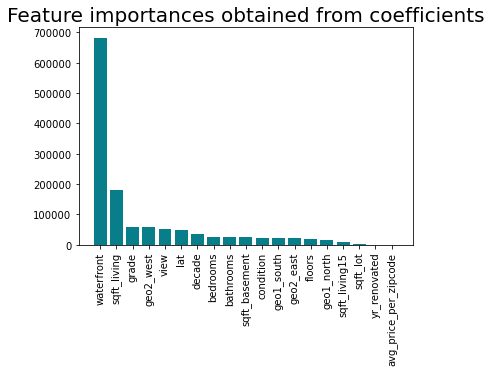

In [49]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train_ready.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [50]:
y_pred=model.predict(X_test_ready)   

In [51]:
R2=r2_score(y_test,y_pred)
R2

0.7739067526167378

In [52]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test_ready.shape[1]-1)
Adj_R2

0.7732416695233361